<a href="https://colab.research.google.com/github/adhello007/PersonalProjects-DeepLearning/blob/main/FacialRecog_ContrastiveLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

from keras.models import Model
from keras.layers import Layer,Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## Folder Structure

In [ ]:
os.getcwd()

'/content'

In [ ]:
os.chdir('/content/drive/MyDrive')

In [ ]:
pos_path = os.path.join('data','positive')
neg_path = os.path.join('data','negative')
anc_path = os.path.join('data','anchor')


In [ ]:
!unzip data.zip

Archive:  data.zip
   creating: data/anchor/
  inflating: data/anchor/b47c234b-7a01-11ee-a4d8-86fac50d5e49.jpg  
  inflating: data/anchor/b487f7a3-7a01-11ee-af4b-86fac50d5e49.jpg  
  inflating: data/anchor/b4992c11-7a01-11ee-9f8d-86fac50d5e49.jpg  
  inflating: data/anchor/b4a02258-7a01-11ee-9ac3-86fac50d5e49.jpg  
  inflating: data/anchor/b4b68e04-7a01-11ee-ae40-86fac50d5e49.jpg  
  inflating: data/anchor/b4c5ad7c-7a01-11ee-a533-86fac50d5e49.jpg  
  inflating: data/anchor/b4df9dde-7a01-11ee-bea0-86fac50d5e49.jpg  
  inflating: data/anchor/b4e46629-7a01-11ee-880f-86fac50d5e49.jpg  
  inflating: data/anchor/b502b52b-7a01-11ee-bba5-86fac50d5e49.jpg  
  inflating: data/anchor/b50d872e-7a01-11ee-8f88-86fac50d5e49.jpg  
  inflating: data/anchor/b511b2e5-7a01-11ee-bfcf-86fac50d5e49.jpg  
  inflating: data/anchor/b51692a3-7a01-11ee-99f9-86fac50d5e49.jpg  
  inflating: data/anchor/b51c37e5-7a01-11ee-9fd8-86fac50d5e49.jpg  
  inflating: data/anchor/b5211b2c-7a01-11ee-95b2-86fac50d5e49.jpg  
  i

## Preprocessing & Creating A Training Pipeline


In [ ]:
#actually creates a pipeline of PATHS using a data generator for all of the different files in a directory.
#takes the path of the images in that directory as parameters
anchor = tf.data.Dataset.list_files(anc_path+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(pos_path+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(neg_path+'/*.jpg').take(300)

In [ ]:
eg = anchor.as_numpy_iterator()

In [ ]:
eg.next()

b'data/anchor/ca95f3d0-7a01-11ee-8665-86fac50d5e49.jpg'

In [ ]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path) #read in the image from file path image as a byte string
    img = tf.io.decode_jpeg(byte_img) # interprets the byte string as a JPEG-encoded image and converts it into a tensor.

    img = tf.image.resize(img,(100,100))
    img = img / 255.
    return img

## Creating the DataSet

In [ ]:
positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

#dataset looks basically like : anchor,positive,array of 1s

In [ ]:
anchor

<_TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [ ]:
sample = data.as_numpy_iterator()

In [ ]:
example = sample.next()
example

(b'data/anchor/b75a266a-7a01-11ee-8b1e-86fac50d5e49.jpg',
 b'data/positive/ff3c16eb-7a01-11ee-9fcc-86fac50d5e49.jpg',
 1.0)

## Build Train & Test Partition

In [ ]:
def preprocess_twin(input_img,validation_img,label):
    return(preprocess(input_img),preprocess(validation_img),label)

In [ ]:
res = preprocess_twin(*example)

In [ ]:
res

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.50490195, 0.44215685, 0.38333333],
         [0.5022059 , 0.43946078, 0.38063726],
         [0.5       , 0.44313726, 0.39019608],
         ...,
         [0.5205882 , 0.52843136, 0.51029414],
         [0.5235294 , 0.52916664, 0.50514704],
         [0.5245098 , 0.52843136, 0.4970588 ]],
 
        [[0.49411765, 0.4343137 , 0.37058824],
         [0.4970588 , 0.44607842, 0.38039216],
         [0.49411765, 0.43995097, 0.3882353 ],
         ...,
         [0.5323529 , 0.5352941 , 0.50392157],
         [0.5352941 , 0.5382353 , 0.50490195],
         [0.54044116, 0.54044116, 0.5012255 ]],
 
        [[0.49117646, 0.44313726, 0.38112745],
         [0.49117646, 0.44142157, 0.38602942],
         [0.5       , 0.44509804, 0.40588236],
         ...,
         [0.5620098 , 0.564951  , 0.5330882 ],
         [0.5656863 , 0.5708333 , 0.53088236],
         [0.5737745 , 0.57965684, 0.5375    ]],
 
        ...,
 
        [[0.5352941 , 0.5       

In [ ]:
#apply this to the entire data
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024) #shuffles positive+ancho and neg+anchor

In [ ]:
samplee = data.as_numpy_iterator()


In [ ]:
eg1 = samplee.next()

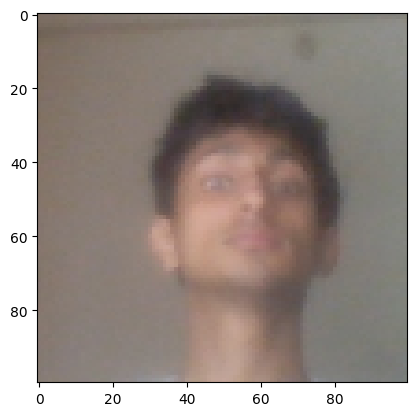

In [ ]:
plt.imshow(eg1[0])

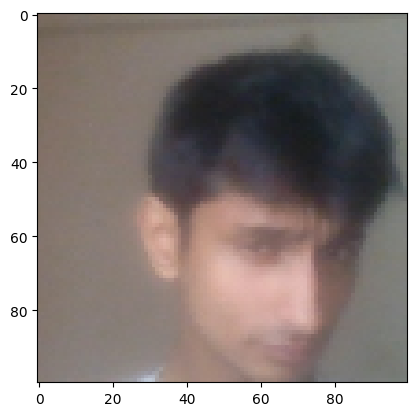

In [ ]:
plt.imshow(eg1[1])

In [ ]:
eg1[2]

1.0

## PARTITION

In [ ]:
len(data) #positive and negative

600

In [ ]:
#Training Partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)

In [ ]:
train_samples = train_data.as_numpy_iterator()

In [ ]:
train_sample = train_samples.next()  #tuple with batched anc, pos/neg img as numpy, and labels as numpy

In [ ]:
train_sample[-1]

array([0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1.],
      dtype=float32)

In [ ]:
#Testing Partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)


In [ ]:
type(test_data)

tensorflow.python.data.ops.batch_op._BatchDataset

In [ ]:
len(train_data)

27

# Building The Model

### Make The Embedding Layer

In [ ]:
def make_embedding():
    inp = Input(shape=(100,100,3))
    c1 = Conv2D(64, (10,10),activation='relu')(inp)
    m1 = MaxPooling2D(64,(2,2),padding='same')(c1)

    c2 = Conv2D(128,(7,7),activation='relu')(m1)
    m2 = MaxPooling2D(64,(2,2),padding='same')(c2)

    c3 = Conv2D(128,(4,4),activation='relu')(m2)
    m3 = MaxPooling2D(256,(4,4),padding='same')(c3)

    #Final Block
    c4 = Conv2D(256,(4,4),activation='relu')(m3)
    f1 = Flatten()(c4)

    d1 = Dense(4096,activation='sigmoid')(f1)

    return Model(inputs=[inp] ,outputs=[d1], name= 'embedding')

In [ ]:
embedding = make_embedding()

In [ ]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

### Build Distance Layer


In [ ]:
class L1Dist(Layer):
    def __init__(self,**kwargs):
        super().__init__()

    def call(self,input_embedding,validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

### Make Siamese Model

In [ ]:
def make_siamese_model():

    #anchor image input in the network
    input_image = Input(name='input_img',shape=(100,100,3))

    #validation image input in the network
    validation_image = Input(name='validation_img',shape=(100,100,3))

    #combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image),embedding(validation_image))

    #classification
    classifier = Dense(1,activation = 'sigmoid')(distances)

    return Model(inputs = [input_image, validation_image],outputs = classifier)

In [ ]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 5406016   ['input_img[0][0]',           
                                                                     'validation_img[0][0]']      
                                                                                              

# Training The Model

### LOSS FUNCTION

keep in mind that the goal of a siamese network isn’t to classify a set of image pairs but instead to differentiate between them. Essentially, contrastive loss is evaluating how good a job the siamese network is distinguishing between the image pairs. The difference is subtle but incredibly important.

In [ ]:
 # Contrastive loss = mean( (1-true_value) * square(prediction) + true_value * square( max(margin-prediction, 0) ))

In [ ]:
opt = tf.keras.optimizers.experimental.RMSprop(
    learning_rate=0.001)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model = siamese_model) #checkpoint object made


In [ ]:
import tensorflow as tf

class CustomContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, margin=1, **kwargs):
        super(CustomContrastiveLoss, self).__init__(**kwargs)
        self.margin = margin

    def call(self, y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(self.margin - y_pred, 0))
        loss = tf.math.reduce_mean((1 - y_true) * square_pred + y_true * margin_square)
        return loss

margin = 1
custom_loss = CustomContrastiveLoss(margin=margin)

In [ ]:
@tf.function  #compiles a function into a callable tensorflow graph
def train_step(batch):
    with tf.GradientTape() as tape: #records operations or automatic differentiation

        X = batch[:2] #get anchor and pos/neg image
        y = batch[2] #get label


        #forward pass
        y_hat = siamese_model(X,training=True)
        #calc loss
        loss = custom_loss(y,y_hat)
        #optimizer
    grad = tape.gradient(loss,siamese_model.trainable_variables)

    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))
    return loss

## Training Loop


In [ ]:
from tqdm import tqdm

log_freq = 10

def train(data, EPOCHS, siamese_model, opt, checkpoint, checkpoint_prefix):
    for epoch in range(1, EPOCHS + 1):
        print(f'\nEpoch {epoch}/{EPOCHS}')
        progbar = tqdm(total=len(data), desc=f'Epoch {epoch}/{EPOCHS}', position=0, leave=True)

        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for idx, batch in enumerate(data):
            loss, y, y_hat = train_step(batch, siamese_model, opt)
            total_loss += loss
            predicted_labels = tf.argmax(y_hat, axis=1)
            correct_predictions += tf.reduce_sum(tf.cast(tf.equal(y, predicted_labels), tf.float32))
            total_samples += y.shape[0]
            progbar.set_postfix(loss=loss.numpy(), accuracy=(correct_predictions / total_samples).numpy())
            progbar.update(1)

        progbar.close()

        if epoch % log_freq == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        avg_loss = total_loss / (idx + 1)
        accuracy = correct_predictions / total_samples
        print(f"\nEpoch {epoch}/{EPOCHS} - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f}")

    print("Training complete.")


In [ ]:
from tqdm import tqdm

def train(data, EPOCHS):
    # Initialize the tqdm progress bar
    progress_bar = tqdm(total=len(data) * EPOCHS, desc='Training', position=0, leave=True)

    # Loop through the epochs
    for epoch in range(1, EPOCHS + 1):
        print('\nEpoch {}/{}'.format(epoch, EPOCHS))

        # Loop through each batch in the dataset
        for idx, batch in enumerate(data):
            # Perform a training step on the current batch
            train_step(batch)

            # Update the progress bar
            progress_bar.update(1)

        # Save checkpoints every 10 epochs
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

    # Close the progress bar after training completion
    progress_bar.close()


In [ ]:
train(train_data,50)

Training:   0%|          | 0/1350 [00:00<?, ?it/s]


Epoch 1/50


Training:   2%|▏         | 29/1350 [00:05<05:21,  4.11it/s]


Epoch 2/50


Training:   4%|▍         | 54/1350 [00:10<03:54,  5.52it/s]


Epoch 3/50


Training:   6%|▌         | 81/1350 [00:15<03:51,  5.47it/s]


Epoch 4/50


Training:   8%|▊         | 108/1350 [00:20<03:45,  5.51it/s]


Epoch 5/50


Training:  10%|█         | 135/1350 [00:24<03:42,  5.45it/s]


Epoch 6/50


Training:  12%|█▏        | 162/1350 [00:29<03:37,  5.47it/s]


Epoch 7/50


Training:  14%|█▍        | 189/1350 [00:34<03:33,  5.43it/s]


Epoch 8/50


Training:  16%|█▌        | 216/1350 [00:39<03:24,  5.55it/s]


Epoch 9/50


Training:  18%|█▊        | 243/1350 [00:43<03:15,  5.68it/s]


Epoch 10/50


Training:  20%|██        | 272/1350 [00:48<03:23,  5.29it/s]


Epoch 11/50


Training:  22%|██▏       | 297/1350 [00:53<02:59,  5.86it/s]


Epoch 12/50


Training:  24%|██▍       | 324/1350 [00:57<02:55,  5.86it/s]


Epoch 13/50


Training:  26%|██▌       | 351/1350 [01:02<02:47,  5.98it/s]


Epoch 14/50


Training:  28%|██▊       | 378/1350 [01:06<02:41,  6.00it/s]


Epoch 15/50


Training:  30%|███       | 405/1350 [01:11<02:37,  5.98it/s]


Epoch 16/50


Training:  32%|███▏      | 432/1350 [01:15<02:35,  5.91it/s]


Epoch 17/50


Training:  34%|███▍      | 459/1350 [01:19<02:30,  5.91it/s]


Epoch 18/50


Training:  36%|███▌      | 486/1350 [01:24<02:23,  6.03it/s]


Epoch 19/50


Training:  38%|███▊      | 513/1350 [01:28<02:18,  6.05it/s]


Epoch 20/50


Training:  40%|████      | 542/1350 [01:33<02:17,  5.90it/s]


Epoch 21/50


Training:  42%|████▏     | 567/1350 [01:37<02:10,  6.01it/s]


Epoch 22/50


Training:  44%|████▍     | 594/1350 [01:41<02:04,  6.06it/s]


Epoch 23/50


Training:  46%|████▌     | 621/1350 [01:46<02:00,  6.06it/s]


Epoch 24/50


Training:  48%|████▊     | 648/1350 [01:50<01:54,  6.14it/s]


Epoch 25/50


Training:  50%|█████     | 675/1350 [01:54<01:51,  6.04it/s]


Epoch 26/50


Training:  52%|█████▏    | 702/1350 [01:59<01:47,  6.01it/s]


Epoch 27/50


Training:  54%|█████▍    | 729/1350 [02:03<01:43,  6.02it/s]


Epoch 28/50


Training:  56%|█████▌    | 756/1350 [02:07<01:39,  5.99it/s]


Epoch 29/50


Training:  58%|█████▊    | 783/1350 [02:12<01:32,  6.13it/s]


Epoch 30/50


Training:  60%|██████    | 812/1350 [02:17<03:06,  2.89it/s]


Epoch 31/50


Training:  62%|██████▏   | 839/1350 [02:22<02:47,  3.05it/s]


Epoch 32/50


Training:  64%|██████▍   | 866/1350 [02:26<01:04,  7.55it/s]


Epoch 33/50


Training:  66%|██████▌   | 893/1350 [02:31<01:00,  7.58it/s]


Epoch 34/50


Training:  68%|██████▊   | 920/1350 [02:35<00:56,  7.63it/s]


Epoch 35/50


Training:  70%|███████   | 947/1350 [02:39<00:52,  7.66it/s]


Epoch 36/50


Training:  72%|███████▏  | 974/1350 [02:43<00:49,  7.64it/s]


Epoch 37/50


Training:  74%|███████▍  | 999/1350 [02:47<00:54,  6.40it/s]


Epoch 38/50


Training:  76%|███████▌  | 1028/1350 [02:51<00:42,  7.50it/s]


Epoch 39/50


Training:  78%|███████▊  | 1055/1350 [02:56<01:35,  3.10it/s]


Epoch 40/50


Training:  80%|████████  | 1082/1350 [03:01<00:44,  5.96it/s]


Epoch 41/50


Training:  82%|████████▏ | 1107/1350 [03:05<00:39,  6.22it/s]


Epoch 42/50


Training:  84%|████████▍ | 1134/1350 [03:09<00:34,  6.30it/s]


Epoch 43/50


Training:  86%|████████▌ | 1161/1350 [03:13<00:30,  6.20it/s]


Epoch 44/50


Training:  88%|████████▊ | 1188/1350 [03:17<00:26,  6.20it/s]


Epoch 45/50


Training:  90%|█████████ | 1215/1350 [03:21<00:21,  6.20it/s]


Epoch 46/50


Training:  92%|█████████▏| 1242/1350 [03:26<00:17,  6.23it/s]


Epoch 47/50


Training:  94%|█████████▍| 1269/1350 [03:30<00:13,  6.20it/s]


Epoch 48/50


Training:  96%|█████████▌| 1296/1350 [03:34<00:08,  6.26it/s]


Epoch 49/50


Training:  98%|█████████▊| 1325/1350 [03:39<00:03,  7.47it/s]


Epoch 50/50


Training: 100%|██████████| 1350/1350 [03:43<00:00,  6.05it/s]


# Evaluate Model

In [ ]:
from tensorflow.keras.metrics import Precision, Recall
#get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
test_input.shape

(16, 100, 100, 3)

In [ ]:
y_hat = siamese_model.predict([test_input,test_val])

1/1 [==============================] - 0s 147ms/step


In [ ]:
y_hat

array([[0.5041649 ],
       [0.5048766 ],
       [0.505119  ],
       [0.5047144 ],
       [0.49729273],
       [0.5050067 ],
       [0.50502557],
       [0.49338758],
       [0.49453995],
       [0.50508785],
       [0.4959504 ],
       [0.4918121 ],
       [0.5051329 ],
       [0.5050346 ],
       [0.49388367],
       [0.50498927]], dtype=float32)

In [ ]:
y_hat = (y_hat >= 0.5).astype(np.float32)

In [ ]:
y_hat

array([[1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.]], dtype=float32)

In [ ]:
y_true

array([1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1.],
      dtype=float32)

###NOW ON THE ENTIRE TEST BATCH

In [ ]:
import numpy as np

y_hat = []
y_true = []


for test_batch in test_data:
    #unpacking the ininputs
    test_input, test_val, y_true1 = test_batch


    y_hat1 = siamese_model.predict([test_input, test_val])
    y_hat.append(y_hat1)
    y_true.append(y_true1)


y_hat = np.concatenate(y_hat, axis=0)
y_true = np.concatenate(y_true, axis=0)

#shapez of the final arrays
print( y_hat.shape)
print( y_true.shape)


1/1 [==============================] - 0s 28ms/step
(180, 1)
(180,)


In [ ]:
y_hat[:10]

array([[0.5049456 ],
       [0.48844504],
       [0.49137336],
       [0.49336174],
       [0.5041558 ],
       [0.504996  ],
       [0.504945  ],
       [0.50486666],
       [0.5050915 ],
       [0.5049885 ]], dtype=float32)

In [ ]:
y_hat = (y_hat >= 0.5).astype(np.float32)

In [ ]:
y_hat.shape

(180, 1)

Text(95.72222222222221, 0.5, 'Ground Truth')

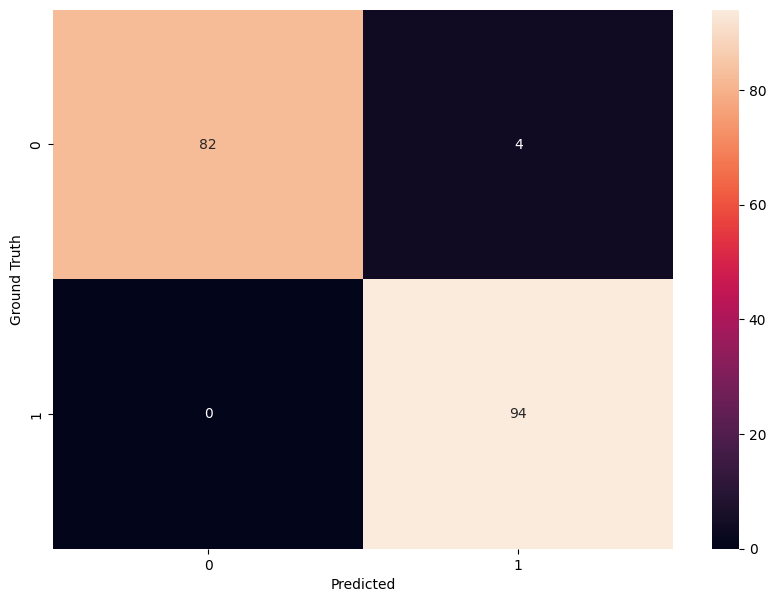

In [ ]:
import seaborn as sns
import tensorflow as tf
cm = tf.math.confusion_matrix(labels=y_true,predictions=y_hat)
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
threshold = 0.5
y_pred_binary = (y_hat > threshold).astype(int)

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

# Print the calculated metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.9591836734693877
Recall: 1.0
F1-score: 0.9791666666666666


# Visualize the Results

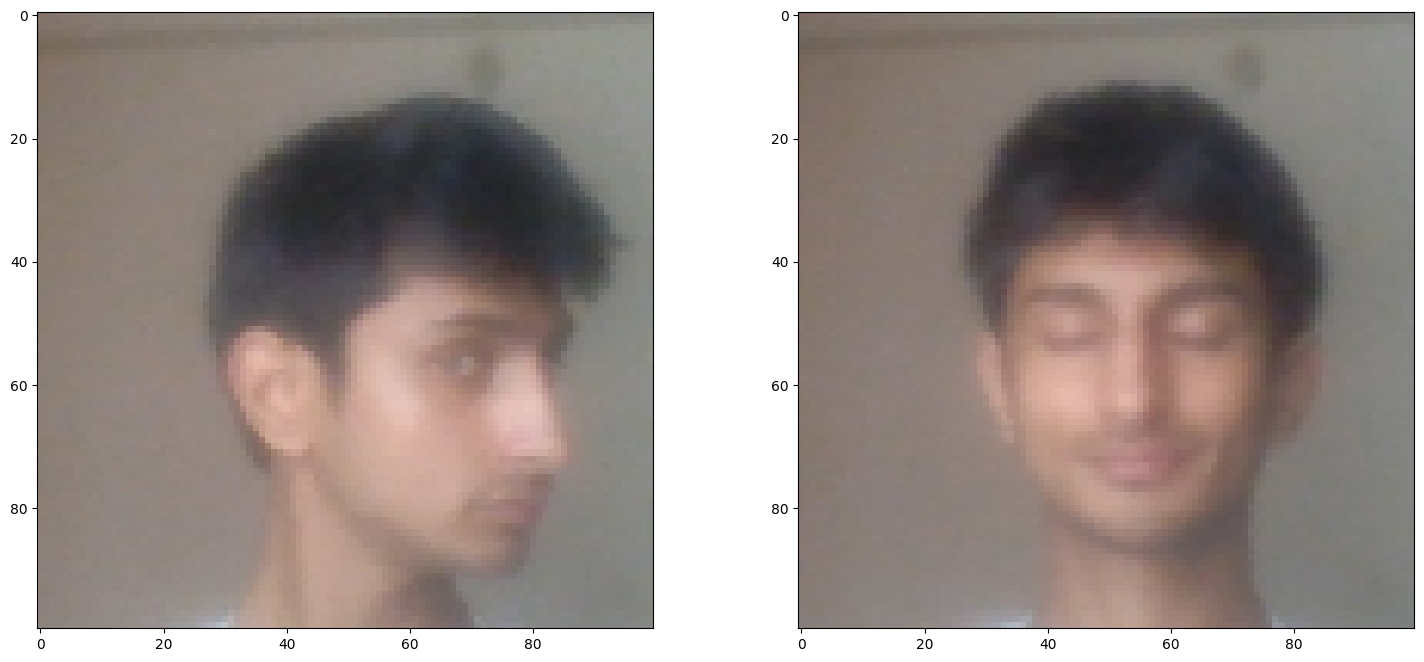

In [ ]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[1])
plt.subplot(1,2,2)
plt.imshow(test_val[1])
plt.show()

# Save Model

In [ ]:
siamese_model.save('siamesemodels.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
